# Task 3. Part 3

Решим задачу регрессии с несколькими целевыми признаками, используя датасет потребления бензина в 48 штатах США.

https://www.kaggle.com/datasets/anikchandra70/petrol-consumption-multivariable-linear-regression

**Описание датасета:**

- Petrol_tax - налог на бензин
- Average_income - средний доход
- Paved_Highways - асфальтированные дороги
- Population_Driver_licence(%) - процент населения с водительскими правами
- Petrol_Consumption - расход бензина

В качестве целевых признаков рассмотрим расход бензина и процент населения с водительскими правами.

In [7]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

%precision %.4f

import warnings
warnings.filterwarnings('ignore')

# 1. Petrol EDA

In [11]:
df = pd.read_csv('petrol_consumption.csv')

In [12]:
df.head()

,Petrol_tax,Average_income,Paved_Highways,Population_Driver_licence(%),Petrol_Consumption
0,9.0,3571,1976,0.525,541
1,9.0,4092,1250,0.572,524
2,9.0,3865,1586,0.580,561
3,7.5,4870,2351,0.529,414
4,8.0,4399,431,0.544,410


In [13]:
df.describe()

,Petrol_tax,Average_income,Paved_Highways,Population_Driver_licence(%),Petrol_Consumption
count,48.000000,48.000000,48.000000,48.000000,48.000000
mean,7.668333,4241.833333,5565.416667,0.570333,576.770833
std,0.950770,573.623768,3491.507166,0.055470,111.885816
min,5.000000,3063.000000,431.000000,0.451000,344.000000
25%,7.000000,3739.000000,3110.250000,0.529750,509.500000
50%,7.500000,4298.000000,4735.500000,0.564500,568.500000
75%,8.125000,4578.750000,7156.000000,0.595250,632.750000
max,10.000000,5342.000000,17782.000000,0.724000,968.000000


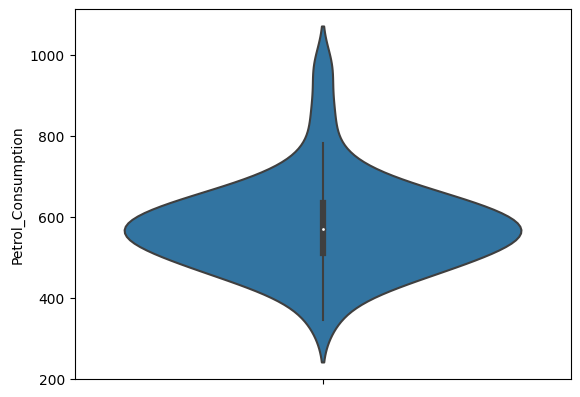

In [39]:
sns.violinplot(y = 'Petrol_Consumption', data = df);

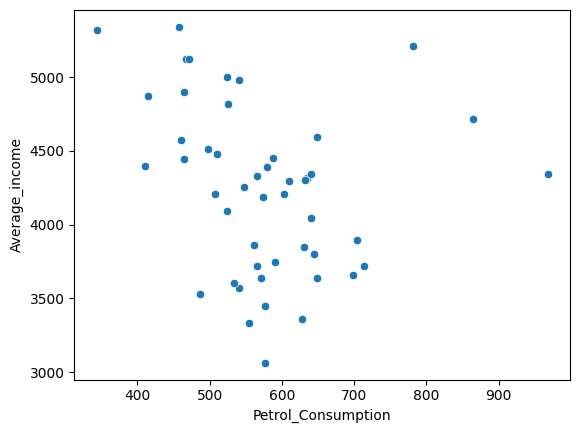

In [27]:
sns.scatterplot(x = 'Petrol_Consumption', y = 'Average_income', data = df);

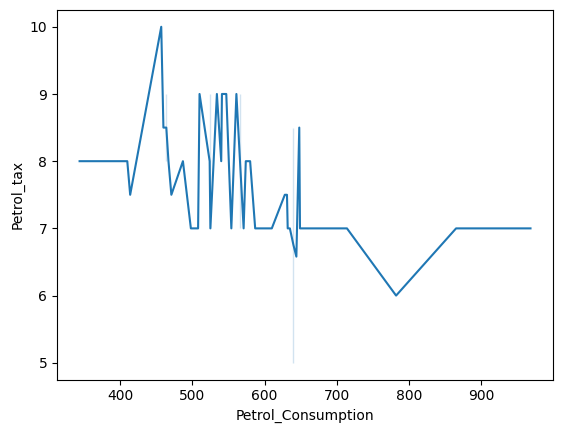

In [30]:
sns.lineplot(y = 'Petrol_tax', x = 'Petrol_Consumption', data = df);

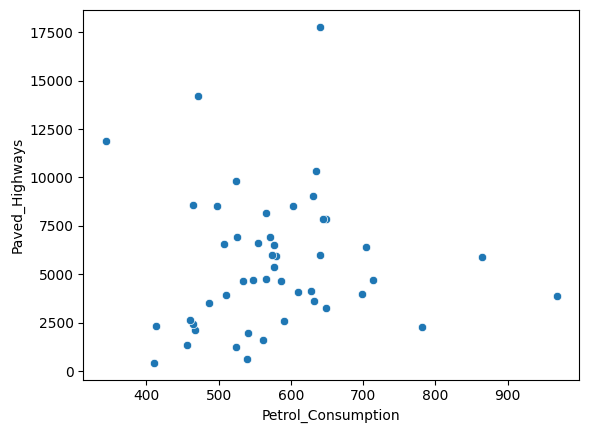

In [25]:
sns.scatterplot(x = 'Petrol_Consumption', y = 'Paved_Highways', data = df);

- Интересно, что люди с меньшим доходом расходуют больше бензина.
- Расход бензина увеличивается с усеньшением налога на бензин.
- В основном, расход бензина растет с количеством асфальтированных дорог, что вполне логично.

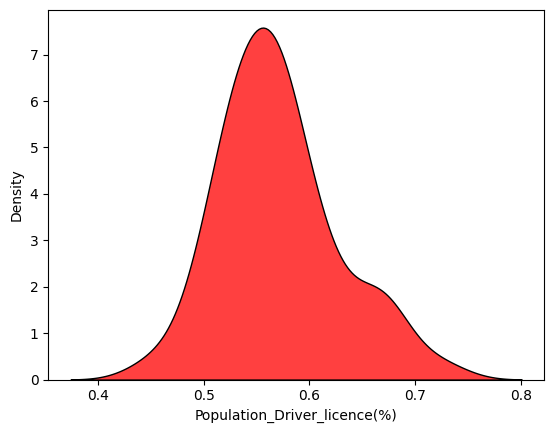

In [34]:
sns.kdeplot(x = 'Population_Driver_licence(%)', data = df, multiple="stack", color = 'red');

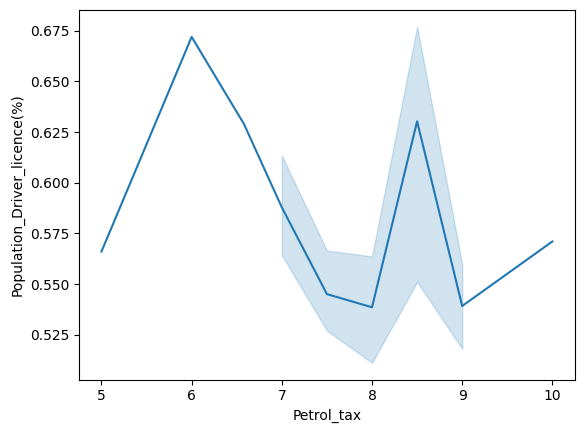

In [44]:
sns.lineplot(x = 'Petrol_tax', y = 'Population_Driver_licence(%)', data = df);

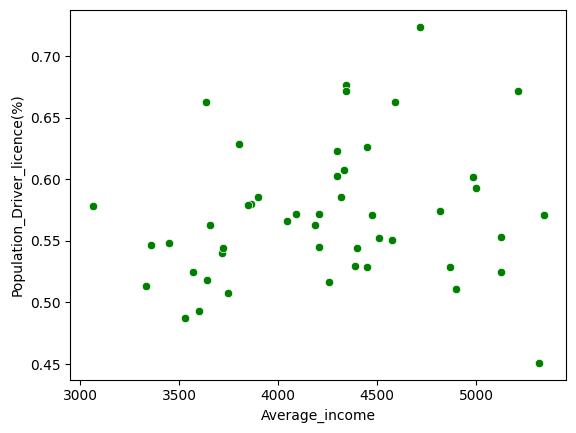

In [47]:
sns.scatterplot(x = 'Average_income', y = 'Population_Driver_licence(%)', data = df, color = 'green');

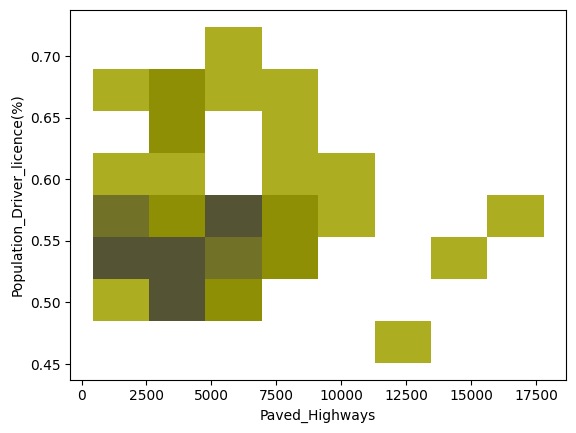

In [48]:
sns.histplot(x = 'Paved_Highways', y = 'Population_Driver_licence(%)', data = df, color = 'yellow');

- Самое большое количество водителей в местах, где налог на бензин низкий - 6 центов и высокий - около 9 центов.
- Чем выше доход населения, тем выше количество водителей.
- Интересно, что самый большой процент людей, управляющих автомобилем, в местах, где меньше пригодных для езды дорог.

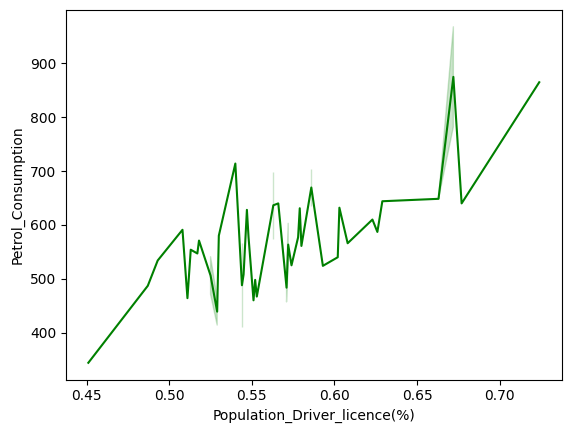

In [50]:
sns.lineplot(y = 'Petrol_Consumption', x = 'Population_Driver_licence(%)', data = df, color = 'green');

Зависимость между целевыми признаками показывает, что с ростом числа водителей увеличивается и потребление бензина, что логично.

# 2. Разбиение данных и масштабирование

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

y = df[['Population_Driver_licence(%)', 'Petrol_Consumption']]
X = df.drop(columns=['Population_Driver_licence(%)', 'Petrol_Consumption'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

# 3. Построение моделей

In [75]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.linear_model import RidgeCV
from time import process_time

MOR = {'Time': 0, 'R2': 0}
RC = {'Time': 0, 'R2': 0}

start_time = process_time()
mor = MultiOutputRegressor(estimator = RidgeCV(alphas = np.linspace(0.1, 1, 100), cv = 5), n_jobs=-1)
mor.fit(X_train_scaled, y_train)
stop_time = process_time()
prediction = mor.predict(X_test_scaled)
MOR['Time'] = stop_time - start_time
MOR['R2'] = r2_score(y_test, prediction)

start_time = process_time()
rc = RegressorChain(RidgeCV(alphas = np.linspace(0.1, 1, 100), cv = 5))
rc.fit(X_train_scaled, y_train)
stop_time = process_time()
prediction = rc.predict(X_test_scaled)
RC['Time'] = stop_time - start_time
RC['R2'] = r2_score(y_test, prediction)


Посмотрим результат

MultiOutputRegressor:


In [76]:
for name in MOR.keys():
    print(f"{name} = {MOR[name]}")

Time = 0.07158900700000004
R2 = 0.04668527164203107


RegressorChain:

In [77]:
for name in RC.keys():
    print(f"{name} = {RC[name]}")

Time = 0.5886636500000009
R2 = 0.04690983496313916


# 4. Вывод

MultiOutputRegressor обучилась почти в 10 раз быстрее, чем RegressorChain, хотя скорость обучения RegressorChain меньше секунды.  Однако модели показали весьма низкую оценку. Как мне кажется, основной причиной невысокой оценки стала сильная нелинейность модели. Также, возможно, процент водителей является не самым удачным целевым признаком.